In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [165]:
train = pd.read_csv("Dataset/train.csv")
train.head()

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes
3,4,wax,6,2.5,unworn,no,NaN
4,5,wax,20,3.0,unworn,no,NaN


In [166]:
le1=LabelEncoder()
le1.fit(train['material'])
train['Encoded_material']=le1.transform(train['material'])

le2=LabelEncoder()
le2.fit(train['tool_condition'])
train['Encoded_tool_condition']=le2.transform(train['tool_condition'])

le3=LabelEncoder()
le3.fit(train['machining_finalized'])
train['Encoded_machining_finalized']=le3.transform(train['machining_finalized'])

le4=LabelEncoder()
le4.fit(train['feedrate'])
train['Encoded_feedrate']=le4.transform(train['feedrate'])

le5=LabelEncoder()
le5.fit(train['clamp_pressure'])
train['Encoded_clamp_pressure']=le5.transform(train['clamp_pressure'])

In [167]:
train.drop(['passed_visual_inspection','tool_condition','material','machining_finalized'],axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   No                           18 non-null     int64  
 1   feedrate                     18 non-null     int64  
 2   clamp_pressure               18 non-null     float64
 3   Encoded_material             18 non-null     int64  
 4   Encoded_tool_condition       18 non-null     int64  
 5   Encoded_machining_finalized  18 non-null     int64  
 6   Encoded_feedrate             18 non-null     int64  
 7   Encoded_clamp_pressure       18 non-null     int64  
dtypes: float64(1), int64(7)
memory usage: 1.2 KB


/home/suhas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


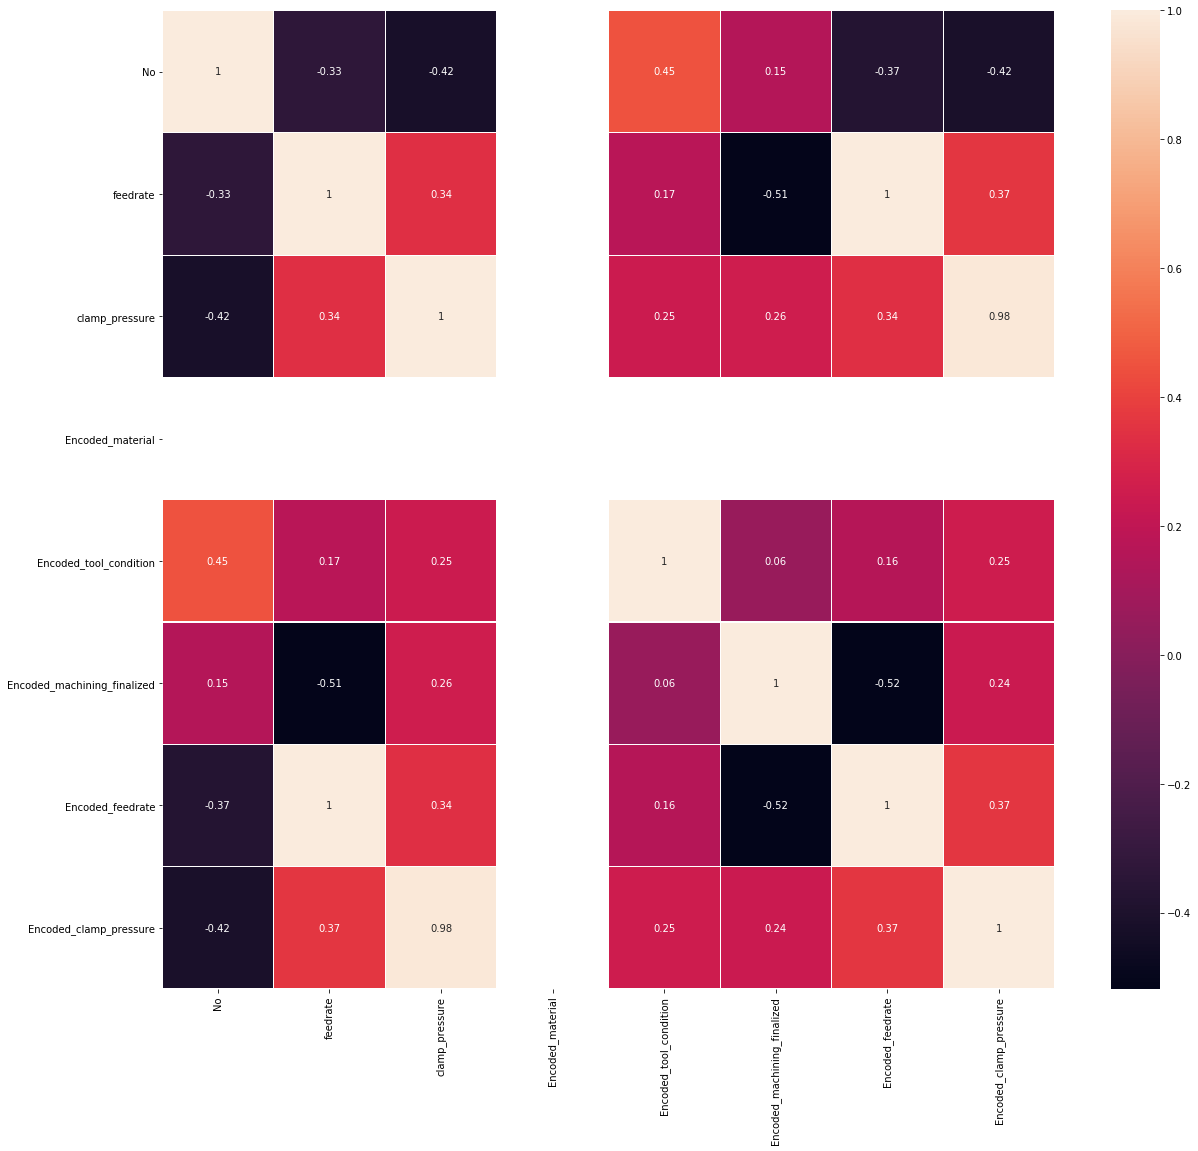

In [168]:
plt.figure(figsize=(20,18))
sns.heatmap(train.corr(),linewidths=.1,annot=True)
plt.show()

In [169]:
frames = []
for i in range(1,19):
    ex_num = '0' + str(i) if i < 10 else str(i)
    frame = pd.read_csv("Dataset/experiment_{}.csv".format(ex_num))

    ex_result_row = train[train['No'] == i]
    
    le6=LabelEncoder()
    le6.fit(frame['Machining_Process'])
    frame['Encoded_Machining_Process']=le6.transform(frame['Machining_Process'])
    frame['Feedrate'] = ex_result_row.iloc[0]['Encoded_feedrate']
    frame['Clamp_pressure'] = ex_result_row.iloc[0]['Encoded_clamp_pressure']
    frames.append(frame)

In [170]:
targets = train["Encoded_tool_condition"]
print(targets)

0     0
1     0
2     0
3     0
4     0
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    1
13    1
14    1
15    1
16    0
17    1
Name: Encoded_tool_condition, dtype: int64


In [171]:
type(frames[0])

pandas.core.frame.DataFrame

In [172]:
len_frames = []
for frame in frames:
    len_frames.append(len(frame))
pd.Series(len_frames).describe()

count      18.000000
mean     1404.777778
std       716.050159
min       462.000000
25%       638.750000
50%      1341.000000
75%      2212.250000
max      2332.000000
dtype: float64

/home/suhas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


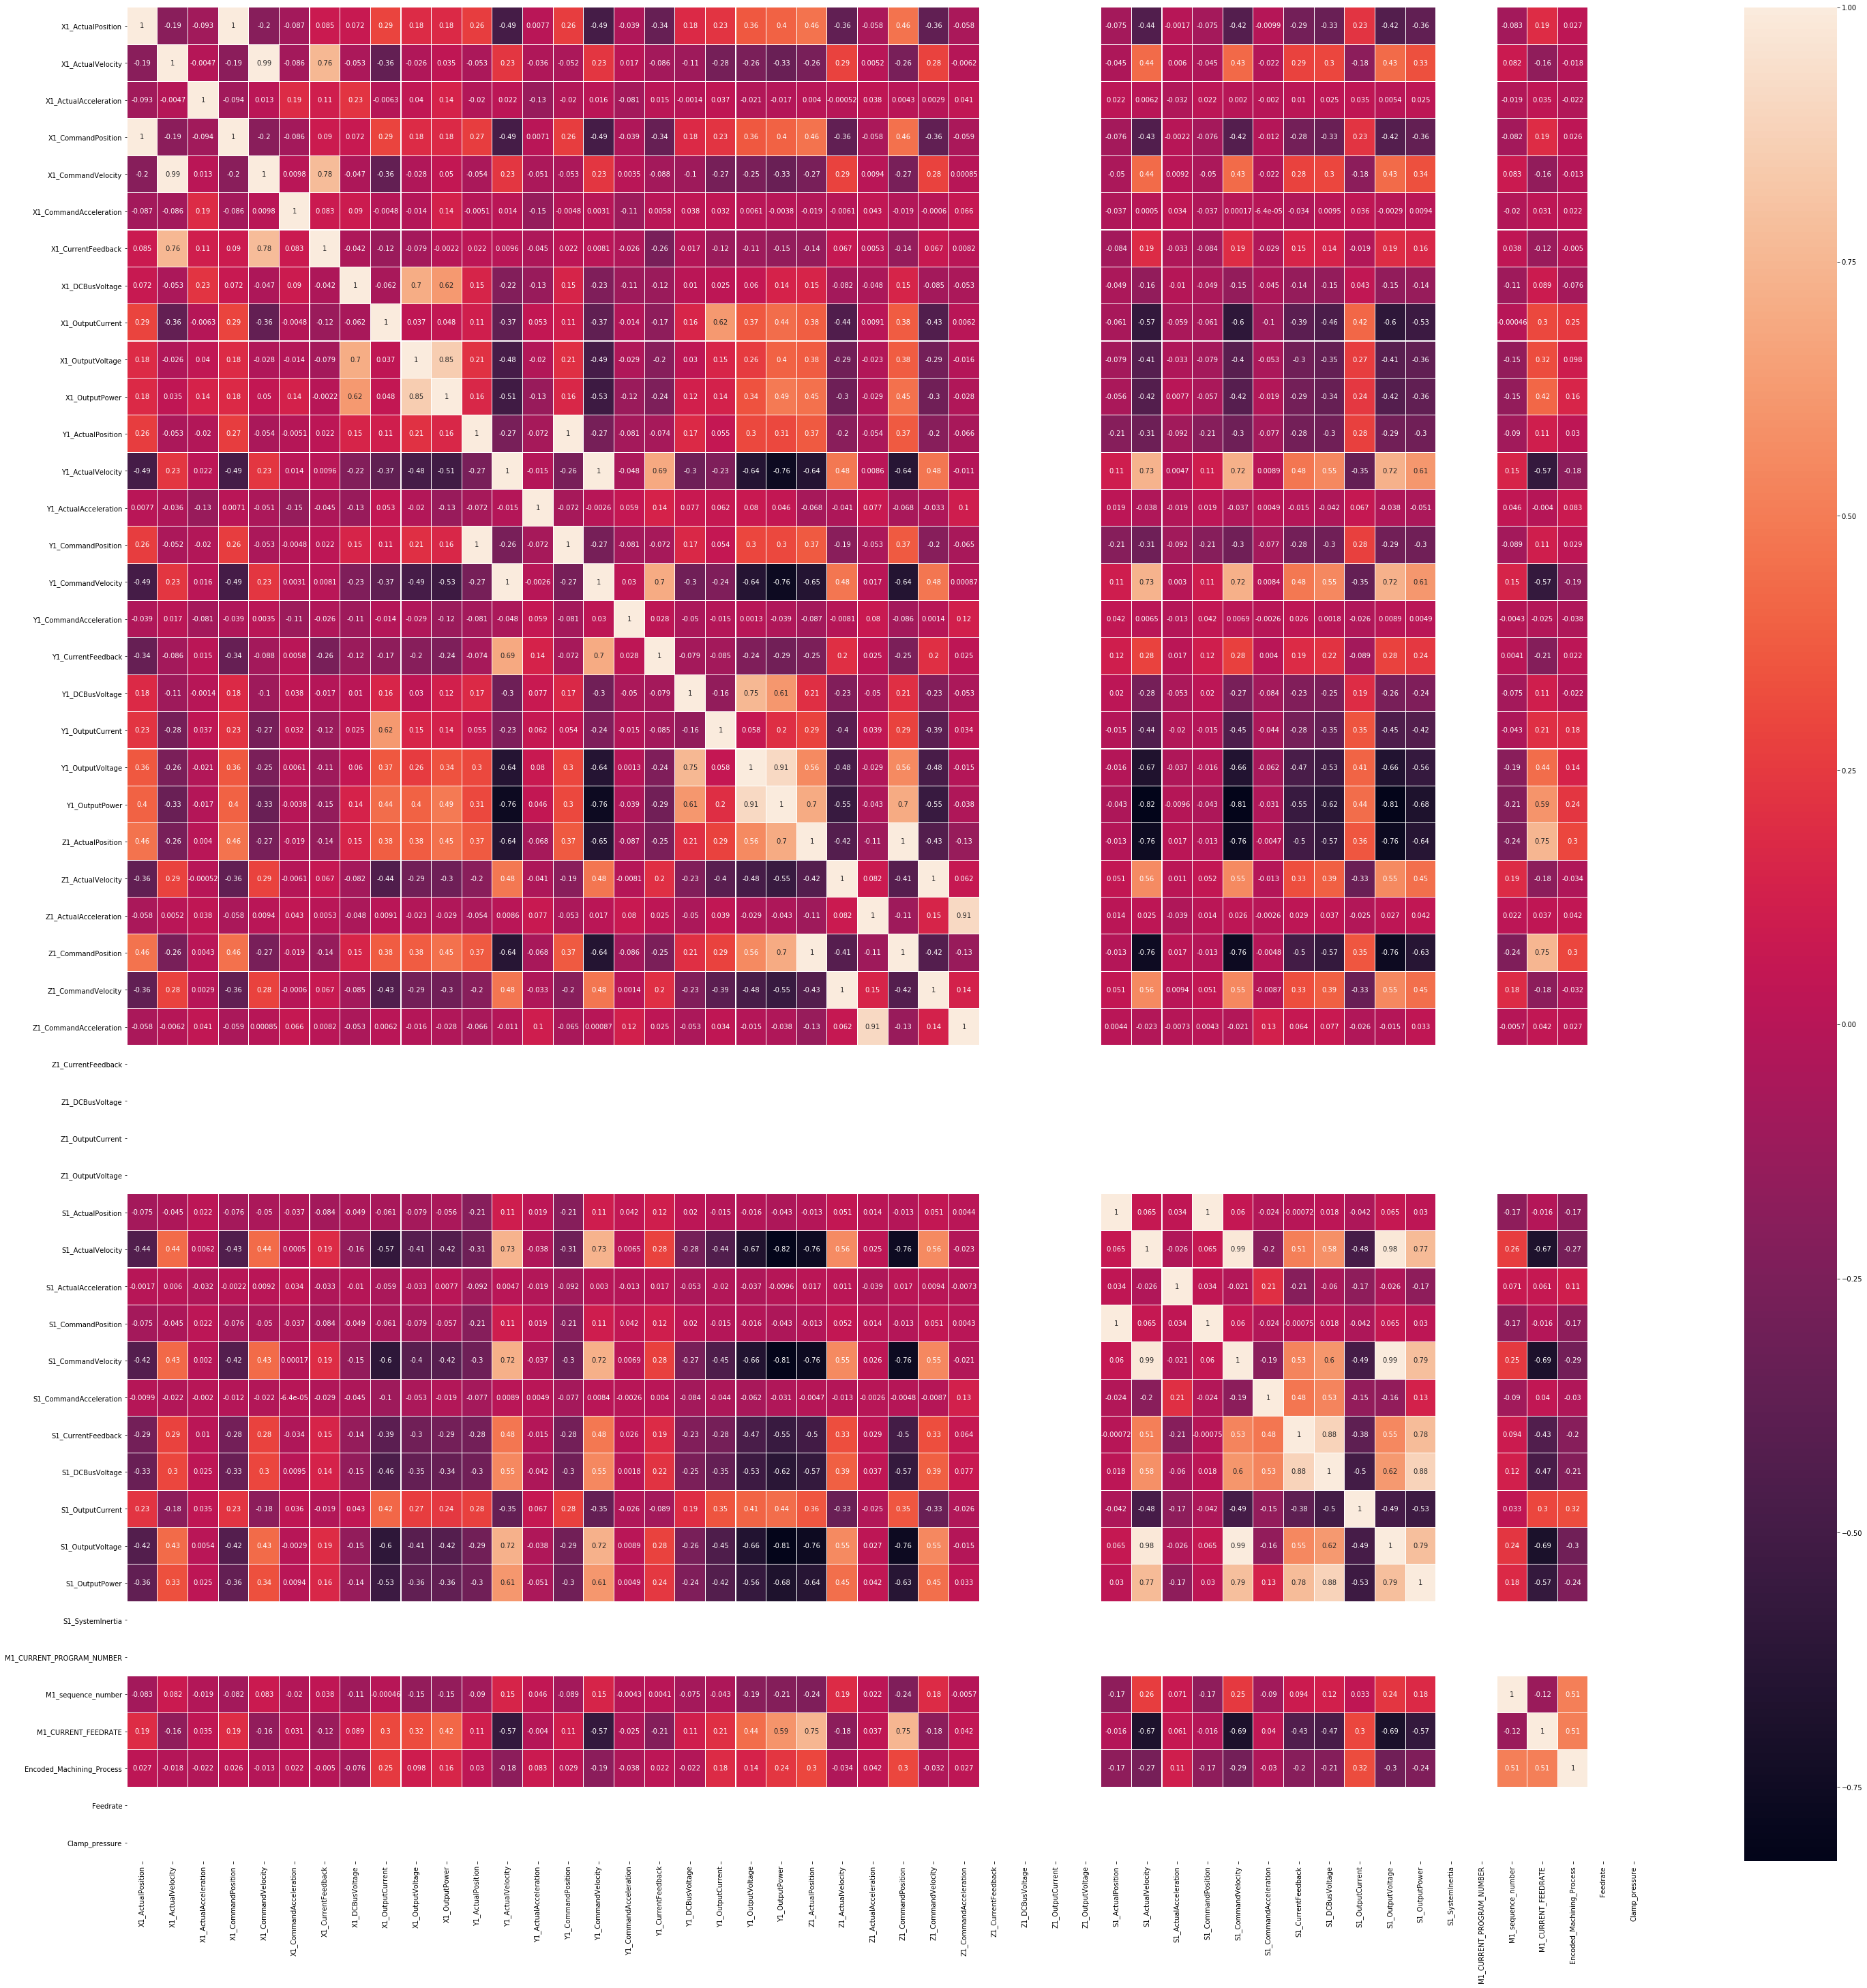

In [173]:
plt.figure(figsize=(50,50))
sns.heatmap(frames[0].corr(),linewidths=.1,annot=True)
plt.show()

In [174]:
sequences = []
scaler = MinMaxScaler()

for frame in frames:
    frame.drop(['Machining_Process','Z1_CurrentFeedback','Z1_DCBusVoltage','Z1_OutputCurrent','Z1_OutputVoltage','S1_SystemInertia'],axis=1,inplace=True)
    data = frame.copy()
    scaled = data.drop(columns = ['Feedrate', 'Clamp_pressure'])
    cols = scaled.columns
    scaled = scaler.fit_transform(scaled.values)
    data[cols] = scaled
    sequences.append(data)

In [175]:
to_pad = 2332
new_frames = []
for seq in sequences:
    seq = seq.values
    len_frame = len(seq)
    last_val = seq[-1]
    n = to_pad - len_frame
    to_concat = np.repeat(seq[-1], n).reshape(45, n).transpose()
    new_frame = np.concatenate([seq, to_concat])
    new_frames.append(new_frame)

final_frames = np.stack(new_frames)

# truncate the sequence to length 2000
from keras.preprocessing import sequence
seq_len = 1500
final_frames = sequence.pad_sequences(final_frames, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [177]:
train_data = np.array(final_frames)
train_y = np.array(train['Encoded_tool_condition'])

In [181]:
import time
import keras
import matplotlib
import random

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import os
import operator
# import utils

# from utils.constants import UNIVARIATE_DATASET_NAMES as DATASET_NAMES
# from utils.constants import UNIVARIATE_ARCHIVE_NAMES  as ARCHIVE_NAMES

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def calculate_metrics(y_true, y_pred, duration):
    res = pd.DataFrame(data=np.zeros((1, 4), dtype=np.float), index=[0],
                       columns=['precision', 'accuracy', 'recall', 'duration'])
    res['precision'] = precision_score(y_true, y_pred, average='macro')
    res['accuracy'] = accuracy_score(y_true, y_pred)
    res['recall'] = recall_score(y_true, y_pred, average='macro')
    res['duration'] = duration
    return res

def plot_epochs_metric(hist, file_name, metric='loss'):
    plt.figure()
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_' + metric])
    plt.title('model ' + metric)
    plt.ylabel(metric, fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

def save_logs(output_directory, hist, y_pred, y_true, duration,lr=True, plot_test_acc=True):
    hist_df = pd.DataFrame(hist.history)
    hist_df.to_csv(output_directory + 'history.csv', index=False)

    df_metrics = calculate_metrics(y_true, y_pred, duration)
    df_metrics.to_csv(output_directory + 'df_metrics.csv', index=False)

    if plot_test_acc:
        # plot losses
        plot_epochs_metric(hist, output_directory + 'epochs_loss.png')

    return df_metrics


class Classifier_INCEPTION:

    def __init__(self, output_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=1,
                 nb_filters=16, use_residual=True, use_bottleneck=True, depth=3, kernel_size=8, nb_epochs=20):

        self.output_directory = output_directory

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose
            self.model.save_weights(self.output_directory + 'model_init.hdf5')

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = keras.layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(keras.layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = keras.layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = keras.layers.Concatenate(axis=2)(conv_list)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)

        x = keras.layers.Add()([shortcut_y, out_tensor])
        x = keras.layers.Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = keras.layers.Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = keras.layers.GlobalAveragePooling1D()(x)

        output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', optimizer='adam',
                      metrics=['accuracy'])

        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50,
                                                      min_lr=0.0001)

        file_path = self.output_directory + 'best_model.hdf5'

        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                           save_best_only=True)

        self.callbacks = [reduce_lr, model_checkpoint]

        return model

    def fit(self, x_train, y_train, x_val, y_val, y_true, plot_test_acc=True):
#         if len(keras.backend.tensorflow_backend._get_available_gpus()) == 0:
#             print('error no gpu')
#             exit()
        # x_val and y_val are only used to monitor the test loss and NOT for training

        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        start_time = time.time()

        if plot_test_acc:

            hist = self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=self.nb_epochs,
                                  verbose=self.verbose, validation_data=(x_val, y_val), callbacks=self.callbacks)
        else:

            hist = self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=self.nb_epochs,
                                  verbose=self.verbose, callbacks=self.callbacks)

        duration = time.time() - start_time

        self.model.save(self.output_directory + 'last_model.hdf5')

        y_pred = self.predict(x_val, y_true, x_train, y_train, y_val,
                              return_df_metrics=False)

        # save predictions
        np.save(self.output_directory + 'y_pred.npy', y_pred)

        # convert the predicted from binary to integer
        y_pred = np.argmax(y_pred, axis=1)
        
        df_metrics = save_logs(self.output_directory, hist, y_pred, y_true, duration, plot_test_acc=plot_test_acc)

        keras.backend.clear_session()

        return df_metrics['accuracy'][0]

    def predict(self, x_test, y_true, x_train, y_train, y_test, return_df_metrics=True):
        start_time = time.time()
        model_path = self.output_directory + 'best_model.hdf5'
        model = keras.models.load_model(model_path)
        y_pred = model.predict(x_test, batch_size=self.batch_size)
        if return_df_metrics:
            y_pred = np.argmax(y_pred, axis=1)
            df_metrics = calculate_metrics(y_true, y_pred, 0.0)
            return df_metrics
        else:
            test_duration = time.time() - start_time
            save_test_duration(self.output_directory + 'test_duration.csv', test_duration)
            return y_pred

In [182]:
import sklearn
    
def prepare_data(x_train, x_test, y_train, y_test):
    
    nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

    # make the min to zero of labels
#     y_train, y_test = transform_labels(y_train, y_test)

    # save orignal y because later we will use binary
    y_true = y_test.astype(np.int64)
    y_true_train = y_train.astype(np.int64)
    # transform the labels from integers to one hot vectors
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, y_true, nb_classes, y_true_train, enc

In [ ]:
from statistics import mean
kf = KFold(n_splits = 3, shuffle = True)
accuracies = []
depth = [3, 6, 9]
kernel = [8, 16]
epocs = [80]
for dep in depth:
    for ker in kernel:
        for epoc in epocs:
            print(dep, ker, epoc)
            scores = []
            for i in range(3):                
                result = next(kf.split(train_data), None)
                x_train = train_data[result[0]]
                x_test = train_data[result[1]]
                y_train = train_y[result[0]]
                y_test = train_y[result[1]]
                x_train, y_train, x_test, y_test, y_true, nb_classes, y_true_train, enc = prepare_data(x_train, x_test, y_train, y_test)
                classifier = Classifier_INCEPTION("/home/suhas/Desktop/LSBU/Outputs" + str(i) + "/", (seq_len, 45), 2, verbose=False, build=True, nb_filters=16, use_residual=True, use_bottleneck=True, depth=dep, kernel_size=ker, nb_epochs=epoc)
                score = classifier.fit(x_train, y_train, x_test, y_test, y_true)
                scores.append(score)
            accuracies.append(mean(scores))
            print(mean(scores))

3 8 80


/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set 

0.5
3 16 80


/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers requi

0.4444444444444444
6 8 80


/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


0.5
6 16 80


/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


0.38888888888888884
9 8 80


/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/suhas/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
